# Importando bibliotecas

In [1]:
import logging
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import time
from datetime import datetime
from torch import nn  # Import the neural network module from PyTorch
from sklearn.model_selection import train_test_split
from stable_baselines3 import DQN, PPO
from stable_baselines3.dqn.policies import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from sklearn.utils import resample
from tensorflow.keras.models import load_model

import sys
from stable_baselines3 import A2C

import os
sys.path.append(os.path.join('..'))
from classes._exploration import exploration
from classes._Env3WGym import Env3WGym
from classes._LoadInstances import LoadInstances
from classes._Agent import Agent
from classes._Supervised import Supervised
from classes._ValidationModel import ValidationModel
from classes._exploration import exploration

# Validação dos dados simulados

In [2]:
if __name__ == '__main__':

    events_names = {
        # 0: 'Normal',
        1: 'Abrupt Increase of BSW',
        # 2: 'Spurious Closure of DHSV',
        # 3: 'Severe Slugging',
        # 4: 'Flow Instability',
        # 5: 'Rapid Productivity Loss',
        # 6: 'Quick Restriction in PCK',
        # 7: 'Scaling in PCK',
        # 8: 'Hydrate in Production Line'
    }

    event_name = [value for key, value in events_names.items() if key != 0][0]
    
    models = ['DQN' , 'PPO', 'A2C'] # 'DQN' , 'PPO', 'A2C', 'RNA'
    type_instance= 'real' # real, simulated
    path_dataset = '..\\..\\..\\dataset'
    instances = LoadInstances(path_dataset)
            
    logging.info(f'Iniciando carregamento do dataset')
    dataset, _ = instances.load_instance_with_numpy(events_names, type_instance=type_instance)    
    logging.info(f'Fim carregamento do dataset')
    
    logging.info(f'Iniciando divisão do dataset em treino e teste')
        
    # Definindo a porcentagem para divisão entre treino e teste
    train_percentage = 0.8  # 80% para treino

    dataset_train_scaled, dataset_test_scaled, dataset_validation_scaled = instances.data_preparation(dataset, train_percentage)

    env_train = Env3WGym(dataset_train_scaled, n_envs = 5)
    env_test = Env3WGym(dataset_test_scaled, n_envs = 1)

    envs_train = env_train.envs_random()
    envs_test = env_test.envs_random()

    path_tensorboard = f'..\\models\\{event_name}-{type_instance}'   
    if not os.path.exists(path_tensorboard):
                os.makedirs(path_tensorboard)

    agente = Agent(path_tensorboard, envs_train, envs_test, TIMESTEPS = 100000)

    list_timesteps = [1000, 10000, 100000, 150000, 300000]
    
    for model_type in models:
        for event_name in [value for key, value in events_names.items() if key != 0]:

            directory = f'..\\..\\logs\\{event_name}-{type_instance}'               
            path_model = f'..\\models\\{event_name}-{type_instance}\\{model_type}'  

            if not os.path.exists(directory):
                os.makedirs(directory)
            
            if not os.path.exists(path_model):
                os.makedirs(path_model)   
                    
            current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            log_filename = f'{directory}\\{current_time}_{event_name}-{type_instance}_{model_type}-log.txt'
            # Configuração do Logging
            logging.basicConfig(filename=log_filename, filemode='w', level=logging.INFO, format='[%(levelname)s]\t%(asctime)s - %(message)s', datefmt='%d/%m/%Y %I:%M:%S %p', force=True, encoding='utf-8')
          
            logging.info(f'Iniciando a execução do algoritmo {model_type}-{type_instance} para o evento {event_name} com timesteps {agente.TIMESTEPS}')
            

            
            if model_type == 'DQN':                
                
                for i in list_timesteps:
                    agente.TIMESTEPS = i
                    try:
                        logging.info(f'Iniciando treinamento do algoritmo DQN {agente.TIMESTEPS} timesteps')    
                        start_time = time.time()                
                        model_agent, replaydir = agente.env3W_dqn(path_save=path_model)  
                        print(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
                        logging.info(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
                        logging.info(f'Fim treinamento do algoritmo DQN')

                        try:
                            logging.info(f'Iniciando avaliação do algoritmo DQN conjunto de teste')
                            accuracy = agente.env3W_dqn_eval(model = model_agent, path_save=path_model)
                            print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando DQN')
                            logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando DQN')
                            logging.info(f'Fim avaliação  do algoritmo DQN conjunto de teste')
                        except Exception as e:
                            logging.error(f'Erro ao avaliar o modelo DQN: {e}')

                    except Exception as e:
                        logging.error(f'Erro ao treinar o modelo DQN: {e}')
                
            elif model_type == 'PPO':      
                
                for i in list_timesteps:
                    agente.TIMESTEPS = i
                    logging.info(f'Iniciando treinamento do algoritmo PPO {agente.TIMESTEPS} timesteps') 
                    start_time = time.time()
                    #agente = Agent(path_model)
                    model_agent = agente.env3W_ppo(path_save=path_model)  
                    print(f"Tempo de Treinamento PPO: {round(time.time() - start_time, 2)}s")
                    logging.info(f"Tempo de Treinamento PPO: {round(time.time() - start_time, 2)}s")
                    logging.info(f'Fim treinamento do algoritmo PPO')
                                
                    logging.info(f'Iniciando avaliação do algoritmo PPO conjunto de teste')
                    accuracy = agente.env3W_ppo_eval(model = model_agent, path_save=path_model)
                    print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando PPO')
                    logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando PPO')
                    logging.info(f'Fim avaliação  do algoritmo PPO conjunto de teste')
               
            elif model_type == 'A2C': 

                for i in list_timesteps:
                    agente.TIMESTEPS = i                
                    try:     
                        logging.info(f'Iniciando treinamento do algoritmo A2C') 
                        start_time = time.time()
                        #agente = Agent(path_model)
                        model_agent = agente.env3W_a2c(path_save=path_model)  
                        print(f"Tempo de Treinamento A2C: {round(time.time() - start_time, 2)}s")
                        logging.info(f"Tempo de Treinamento A2C: {round(time.time() - start_time, 2)}s")
                        logging.info(f'Fim treinamento do algoritmo A2C')
                    
                        try:
                            logging.info(f'Iniciando avaliação do algoritmo A2C conjunto de teste')
                            accuracy = agente.env3W_a2c_eval(model = model_agent, path_save=path_model)
                            print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando A2C')
                            logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando A2C')
                            logging.info(f'Fim avaliação  do algoritmo A2C conjunto de teste')
                        except Exception as e:
                            logging.error(f'Erro ao avaliar o modelo A2C: {e}')

                    except Exception as e:
                        logging.error(f'Erro ao treinar o modelo A2C: {e}')
            
            elif model_type == 'RNA':
                try:
                    logging.info(f'Iniciando treinamento do modelo RNA') 
                    dataset_train_scaled[:, -1] = np.where(dataset_train_scaled[:, -1] == 101, 1, dataset_train_scaled[:, -1])
                    dataset_test_scaled[:, -1] = np.where(dataset_test_scaled[:, -1] == 101, 1, dataset_test_scaled[:, -1])
                    supervised = Supervised(path_model, dataset_train_scaled, dataset_test_scaled)
                    start_time = time.time()
                    model_agent = supervised.keras_train()  
                    print(f"Tempo de Treinamento RNA: {round(time.time() - start_time, 2)}s")
                    logging.info(f"Tempo de Treinamento RNA: {round(time.time() - start_time, 2)}s")
                    logging.info(f'Fim treinamento do modelo RNA')

                    try:
                        logging.info(f'Iniciando avaliação do modelo RNA conjunto de teste')
                        accuracy = supervised.keras_evaluate(model_agent)
                        print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando RNA')
                        logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando RNA')
                        logging.info(f'Fim avaliação  do modelo RNA conjunto de teste')
                    except Exception as e:
                        logging.error(f'Erro ao treinar o modelo RNA: {e}')
                except Exception as e:
                    logging.error(f'Erro ao treinar o modelo RNA: {e}')

            #logging.info(f'Iniciando a validação do modelo {model_type}') 
            #validation = ValidationModel(model_type, event_name)
            #validation.validation_model(accuracy, dataset_validation_scaled, model_agent)

            logging.info(f'Concluído a execução do algoritmo {model_type}-{type_instance} para o evento {event_name}')
            # Para fechar explicitamente o arquivo de log, obtenha todos os handlers do root logger e feche-os
            for handler in logging.root.handlers[:]:
                handler.close()
                logging.root.removeHandler(handler)
   

Número de amostras da classe 0.0: 195376
Número de amostras da classe 1.0: 10417
Número de amostras da classe 101.0: 95658


c:\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


TensorBoard started at http://localhost:6006/
Para visualizar os logs do TensorBoard, execute:
tensorboard --logdir='..\models\Abrupt Increase of BSW-real\tensorboard_logs'
Tempo de Treinamento DQN: 0.65s
Acurácia de 29.17% no conjunto de dados de teste usando DQN
Para visualizar os logs do TensorBoard, execute:
tensorboard --logdir='..\models\Abrupt Increase of BSW-real\tensorboard_logs'
Tempo de Treinamento DQN: 5.26s
Acurácia de 72.75% no conjunto de dados de teste usando DQN
Para visualizar os logs do TensorBoard, execute:
tensorboard --logdir='..\models\Abrupt Increase of BSW-real\tensorboard_logs'
Tempo de Treinamento DQN: 70.02s
Acurácia de 92.34% no conjunto de dados de teste usando DQN
Para visualizar os logs do TensorBoard, execute:
tensorboard --logdir='..\models\Abrupt Increase of BSW-real\tensorboard_logs'
Tempo de Treinamento DQN: 114.96s
Acurácia de 93.02% no conjunto de dados de teste usando DQN
Para visualizar os logs do TensorBoard, execute:
tensorboard --logdir='..\m

# Validação com dados reais

In [ ]:
if __name__ == '__main__':

    events_names = {
        # 0: 'Normal',
        1: 'Abrupt Increase of BSW',
        # 2: 'Spurious Closure of DHSV',
        # 3: 'Severe Slugging',
        # 4: 'Flow Instability',
        # 5: 'Rapid Productivity Loss',
        # 6: 'Quick Restriction in PCK',
        # 7: 'Scaling in PCK',
        # 8: 'Hydrate in Production Line'
    }

    event_name = [value for key, value in events_names.items() if key != 0][0]
    
    models = ['DQN'] # 'DQN' 
    type_instance= 'real' # real, simulated
    path_dataset = '..\\..\\..\\dataset'
    instances = LoadInstances(path_dataset)
    model_type = models[0]
            
    logging.info(f'Iniciando carregamento do dataset')
    dataset, _ = instances.load_instance_with_numpy(events_names, type_instance=type_instance)    
    logging.info(f'Fim carregamento do dataset')    
    
    logging.info(f'Iniciando divisão do dataset em treino e teste')        
    # Definindo a porcentagem para divisão entre treino e teste
    train_percentage = 0.8  # 80% para treino
    dataset_train_scaled, dataset_test_scaled, dataset_validation_scaled = instances.data_preparation(dataset, train_percentage)
   
    env_train = Env3WGym(dataset_train_scaled, n_envs = 5)
    env_test = Env3WGym(dataset_test_scaled, n_envs = 1)

    envs_train = env_train.envs_random()
    envs_test = env_test.envs_random()

    env_test_cl = Env3WGym(dataset_test_scaled, n_envs = 5)
    envs_cl = env_test_cl.envs_random()

    directory = f'..\\..\\logs\\{event_name}-{type_instance}-CL'
    path_dataset = '..\\..\\..\\dataset'   
    path_model = f'..\\models\\{event_name}-{type_instance}\\{model_type}'  

    if not os.path.exists(directory):
        os.makedirs(directory)

    if not os.path.exists(path_model):
        os.makedirs(path_model)    

    path_tensorboard = f'..\\models\\{event_name}-{type_instance}-CL'   
    if not os.path.exists(path_tensorboard):
        os.makedirs(path_tensorboard)

    agente = Agent(path_tensorboard, envs_train, envs_test, TIMESTEPS = 100000)            

            
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    log_filename = f'{directory}\\{current_time}_{event_name}-{type_instance}_{model_type}-log.txt'
    # Configuração do Logging
    logging.basicConfig(filename=log_filename, filemode='w', level=logging.INFO, 
                        format='[%(levelname)s]\t%(asctime)s - %(message)s', 
                        datefmt='%d/%m/%Y %I:%M:%S %p', force=True, encoding='utf-8')
   

    if model_type == 'DQN':
        
        logging.info(f'Iniciando o teste do algoritmo DQN (Continual Learning)')    
        #start_time = time.time()
        #model_agent = agente.env3W_dqn(path_save=path_model)  
        #print(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
        #logging.info(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
        #logging.info(f'Fim treinamento do algoritmo DQN')
        

        # Carrega o modelo treinado em simulação com 100k passos
        path_model_zip = os.path.join("..", "models", "Abrupt Increase of BSW-simulated", "DQN", "_DQN.zip")
        
        # Avalia o modelo treinado em simulação com 100k passos no ambiente real
        model_agent = DQN.load(path_model_zip) 
        logging.info(f'Iniciando avaliação do algoritmo DQN conjunto de teste')
        accuracy = agente.env3W_dqn_eval(model = model_agent, path_save=path_model)
        print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando DQN')
        logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando DQN')
        logging.info(f'Fim avaliação  do algoritmo DQN conjunto de teste')

        # Carrega o replay buffer do modelo treinado em simulação com 100k passos 
        replay_buffer_path = os.path.join("..", "models", "Abrupt Increase of BSW-simulated", "DQN", "replay_buffer", "dqn_save_replay_buffer.pkl")
        
        # Retreina o modelo com o replay buffer do modelo treinado em simulação com 10k passos do modelo real
        model_agent_cl = agente.env3W_dqn_cl(model_agent = model_agent, path_save=path_model, envs = envs_cl, 
                                             replaydir = replay_buffer_path, total_timesteps = 50000)
        
        # Avalia o modelo retreinado com 10k passos do ambiente real
        logging.info(f'Iniciando avaliação do algoritmo DQN conjunto de teste (Continual Learning)')
        accuracy = agente.env3W_dqn_eval(model = model_agent_cl, path_save=path_model)
        print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando DQN (Continual Learning)')
        logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando DQN (Continual Learning)')
        logging.info(f'Fim avaliação  do algoritmo DQN conjunto de teste (Continual Learning)')   

    # Para fechar explicitamente o arquivo de log, obtenha todos os handlers do root logger e feche-os
    for handler in logging.root.handlers[:]:
        handler.close()
        logging.root.removeHandler(handler)
    

# Geração de gráficos

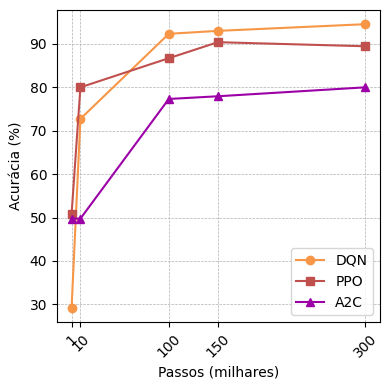

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Dados extraídos das imagens
modelos = ['A2C', 'DQN', 'PPO']
passos = np.array([1, 10, 100, 150, 300])  # Representando 10k passos de intervalo

# Acurácia dos modelos com 10k em 10k passos, convertendo para porcentagem
valores_DQN = np.array([0.29166, 0.72747, 0.92344, 0.93021, 0.94559]) * 100
valores_PPO = np.array([0.50828, 0.80014, 0.86720, 0.90412, 0.89472]) * 100
valores_A2C = np.array([0.49757, 0.49757, 0.77329, 0.77952, 0.80008]) * 100

plt.figure(figsize=(4, 4))

# Plots para cada modelo
plt.plot(passos, valores_DQN, marker='o', color='#F79646', label='DQN')
plt.plot(passos, valores_PPO, marker='s', color='#C0504D', label='PPO')
plt.plot(passos, valores_A2C, marker='^', color='#9C00A7', label='A2C')  # Alterado para melhor visibilidade

# Personalizações
plt.xlabel('Passos (milhares)')
plt.ylabel('Acurácia (%)')
plt.xticks(passos, rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.savefig('..\\..\\img\\grafico_acuracia3.png', dpi=300)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dados extraídos das imagens
modelos = ['A2C', 'DQN', 'PPO']

# Acurácia dos modelos com 10k em 10k passos
valores_DQN = [0.7911,
  0.87225,
  0.9013,
  0.87937,
  0.92252,
  0.91683,
  0.93927,
  0.9493,
  0.88589,
  0.94434,
  0.50395,
  0.93821,
  0.90226,
  0.81794,
  0.88619,
  0.84911,
  0.62753,
  0.71075,
  0.9028,
  0.95265,
  0.91927,
  0.88583,
  0.9227,
  0.92264,
  0.93083,
  0.94742,
  0.95284,
  0.94246,
  0.94742,
  0.94083]
#[80.76, 88.11, 94, 91.53, 86.73, 94.24, 92.25, 94.84, 82.84, 90.07]
valores_PPO = [0.74739,
  0.79719,
  0.8091,
  0.40587,
  0.81019,
  0.76256,
  0.40587,
  0.75161,
  0.80943,
  0.80385,
  0.81926,
  0.79612,
  0.8465,
  0.78194,
  0.81106,
  0.39265,
  0.39265,
  0.39265,
  0.3973,
  0.433,
  0.76758,
  0.40685,
  0.40168,
  0.40472,
  0.81062,
  0.80889,
  0.27819,
  0.80542,
  0.78754,
  0.80283]
#[80.51, 67.62, 81,  40.11, 40.49, 80.36, 79.21, 79.74, 77.66, 40.48]
valores_A2C = accuracies = [
    0.50870, 0.50730, 0.50440, 0.50704, 0.50900,
    0.50388, 0.51218, 0.50802, 0.51214, 0.55713,
    0.50500, 0.51191, 0.50919, 0.51024, 0.50741,
    0.50582, 0.50376, 0.50029, 0.49884, 0.49658,
    0.49522, 0.49387, 0.49241, 0.49095, 0.48950,
    0.48804, 0.48659, 0.48513, 0.48368, 0.48223
]

# multiplicando por 100 para obter a porcentagem
valores_DQN = [x * 100 for x in valores_DQN]
valores_PPO = [x * 100 for x in valores_PPO]
valores_A2C = [x * 100 for x in valores_A2C]


#[50.25, 49.87, 50.47, 50.43, 51.19, 50.82, 50.42, 50.75, 51.26, 50.99]

passos = np.arange(10, 301, 10)  # Representando 10k passos de intervalo, de 10k até 100k

plt.figure(figsize=(8, 4))

# Plots para cada modelo
plt.plot(passos, valores_DQN, marker='o', color='#F79646', label='DQN')
plt.plot(passos, valores_PPO, marker='s', color='#C0504D', label='PPO')
plt.plot(passos, valores_A2C, marker='^', color='#FF3399', label='A2C')

# Adicionando rótulos, título e personalizando eixos
plt.xlabel('Passos (em milhares)') # , fontweight='bold'
plt.ylabel('Acurácia %') # , fontweight='bold'
#plt.title('Comparação da Acurácia dos Modelos por Passos')
plt.xticks(passos)
plt.legend()
# colocar em 45 graus
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.savefig('..\\..\\img\\grafico_acuracia2.png', dpi=300)
plt.show()


# Exploração dos dados

In [17]:
events_names = {
    # 0: 'Normal',
    1: 'Abrupt Increase of BSW',
    # 2: 'Spurious Closure of DHSV',
    # 3: 'Severe Slugging',
    # 4: 'Flow Instability',
    # 5: 'Rapid Productivity Loss',
    # 6: 'Quick Restriction in PCK',
    # 7: 'Scaling in PCK',
    # 8: 'Hydrate in Production Line'
}

event_name = [value for key, value in events_names.items() if key != 0][0]


type_instance='real'

instances = LoadInstances(path_dataset)
            

dataset, _ = instances.load_instance_with_numpy(events_names, type_instance=type_instance)

INFO:root:Total de  1019 instâncias real encontradas.
INFO:root:Total de 5 instâncias real carregadas para o evento Abrupt Increase of BSW.


In [18]:


explora = exploration(pd.DataFrame(dataset, columns=['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class']))

explora.quartiles_plot(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP'], f'Quartis das variáveis {type_instance} do evento {event_name}')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
c:\Users\kaike\Documents\UFSC\3W\Reinforcement-Learning\src\notebook\..\classes\_exploration.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=var, data=filtered_data, ax=axes[i], palette=class_palette, showfliers=False)
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appro

array([['2017-07-31 18:09:30', 44858050.0, 18373560.0, ..., 2538033.0,
        78.87206, '0'],
       ['2017-07-31 18:09:31', 44858050.0, 18373560.0, ..., 2538033.0,
        78.87207, '0'],
       ['2017-07-31 18:09:32', 44858050.0, 18373560.0, ..., 2538032.0,
        78.87208, '0'],
       ...,
       ['2018-06-18 10:59:58', -1.180116e+42, 20647810.0, ...,
        10138120.0, 71.27946, '1'],
       ['2018-06-18 10:59:59', -1.180116e+42, 20647810.0, ...,
        10138830.0, 71.27944, '1'],
       ['2018-06-18 11:00:00', -1.180116e+42, 20647810.0, ...,
        10139540.0, 71.27942, '1']], dtype=object)